Věrohodnost

In [2]:
import numpy as np
import pandas as pd 


import matplotlib.pyplot as plt
import scipy.optimize as optimize
import scipy
import seaborn as sns
import json
from zipfile import ZipFile

In [32]:
# load data
fileName = "Data_2024.xlsx"
df = pd.read_excel(fileName, sheet_name="Data_věrohodnost") # need pip install xlrd and openpyxl
df = df.iloc[:, :-2] # remove columns without information
# check types
df['censored'] = df['censored'].astype(int)
df['doba práce v oboru [roky]'] = df['doba práce v oboru [roky]'].astype(float)
print(df)

     censored  doba práce v oboru [roky]
0           0                      6.528
1           0                      6.013
2           1                      6.055
3           0                      7.243
4           1                      5.629
..        ...                        ...
316         1                      5.562
317         0                      5.491
318         0                      6.761
319         0                      7.062
320         0                      5.784

[321 rows x 2 columns]


f(x;lambda, k) = 

In [33]:
from scipy.optimize import minimize

def log_likelihood(params, x, censor):
    k, lamb = params
    return -np.sum(censor * (np.log(k) - np.log(lamb) + (k-1) * np.log(x/lamb) - (x/lamb)**k) + (1-censor) * (-(x/lamb)**k))
    #return - (n * np.log(k) - n*k*np.log(lamb) + (k-1)* np.sum(np.log(x)) - np.sum((x/lamb)**k))

init_guess = [1, 1]
    
# Define the bounds for the parameters
bounds = [(0, None), (0, None)]
    
x = df['doba práce v oboru [roky]'].values
censored = df['censored'].values

# Perform the optimization
res = minimize(log_likelihood, init_guess, args=(x, censored), method="SLSQP", bounds=bounds)

print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 249.31509175824306
       x: [ 6.490e+00  8.641e+00]
     nit: 16
     jac: [-2.670e-05  6.866e-05]
    nfev: 61
    njev: 16


In [34]:
import surpyval as surv

# Failures
f = [1, 4, 5, 7, 8, 10]

# suspended or right-censored points
s = [5, 6, 7]

# Convert 'fs' format to the 'xcn' format 
# x is the time/variable
# c is the censoring flag 0 = failed, 1 = right-censored
# n is the count

x, c, n = surv.fs_to_xcn(f=f, s=s)
# Fit model
surv.Weibull.fit(x, c, n)

Parametric SurPyval Model
Distribution        : Weibull
Fitted by           : MLE
Parameters          :
     alpha: 7.738077941578665
      beta: 2.263120966029976

In [6]:
import surpyval as surv
values = df['doba práce v oboru [roky]'].values

# 0 = failed, 1 = right censored
censored = df['censored'].values

model = surv.Weibull.fit(values, c=censored)
print(model.params)

[7.42946141 6.17281648]


In [54]:
x = df['doba práce v oboru [roky]'].values

# 0 = failed, 1 = right censored
censored = df['censored'].values

# Logaritmická věrohodnost pro cenzorovaná data
def log_likelihood(params):
    k, lam = params
    if k <= 0 or lam <= 0:
        return np.inf  # Parametry musí být kladné
    # Hustota a přeživší funkce
    pdf = (k / lam) * (x / lam)**(k - 1) * np.exp(-(x / lam)**k)  # Hustota
    sf = np.exp(-(x / lam)**k)  # Přeživší funkce
    # Logaritmická věrohodnost
    log_l = (1 - censored) * np.log(pdf) + censored * np.log(sf)
    return -np.sum(log_l)  # Negace pro minimalizaci

# Počáteční odhady
initial_params = [1.0, 1.0]

# Optimalizace
result = minimize(log_likelihood, initial_params, method='L-BFGS-B', bounds=((1e-5, None), (1e-5, None)))

# Výsledky
if result.success:
    k_hat, lam_hat = result.x
    print(f"Odhadnuté parametry: k = {k_hat:.4f}, λ = {lam_hat:.4f}")
else:
    print("Optimalizace selhala:", result.message)

Odhadnuté parametry: k = 6.1728, λ = 7.4295


In [53]:
x = df['doba práce v oboru [roky]'].values

# 0 = failed, 1 = right censored
censored = df['censored'].values
# Negative log-likelihood with improved stability
def negative_log_likelihood(params):
    k, lam = params
    if k <= 0 or lam <= 0:  # Ensure positive parameters
        return np.inf

    # Uncensored contribution f(x) original 
    uncensored_loglik = np.log((k / lam) * (x[~censored] / lam) ** (k - 1) * np.exp(-(x[~censored] / lam) ** k))
    # Censored contribution (1- F(x)) log likelihood
    censored_loglik = np.log(1 - ((1/k) - np.log(lam) + np.log(x[censored]) - np.log(x[censored] / lam) * ((x[censored]/lam) ** k)))#(np.exp(-(x[censored] / lam) ** k)*(k/lam)*((x[censored]/lam)**(k-1))))

    # Combine and return negative log-likelihood
    nll = -(np.sum(uncensored_loglik) + np.sum(censored_loglik))
    return nll

initial_guess = [1, 1]
# Optimize with refined settings
result = minimize(negative_log_likelihood, initial_guess, method="L-BFGS-B")

# Display results
print(result)
k_mle, lambda_mle = result.x
print(f"Odhadnuté parametry: k = {k_mle:.8f}, lambda = {lambda_mle:.8f}")


  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: inf
        x: [ 1.000e+00  1.000e+00]
      nit: 0
      jac: [ 1.940e+03 -1.094e+03]
     nfev: 63
     njev: 21
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
Odhadnuté parametry: k = 1.00000000, lambda = 1.00000000


C:\Users\marti\AppData\Local\Temp\ipykernel_11856\4240214372.py:14: RuntimeWarning: invalid value encountered in log
  censored_loglik = np.log(1 - ((1/k) - np.log(lam) + np.log(x[censored]) - np.log(x[censored] / lam) * ((x[censored]/lam) ** k)))#(np.exp(-(x[censored] / lam) ** k)*(k/lam)*((x[censored]/lam)**(k-1))))
c:\Users\marti\anaconda3\envs\aidojo\Lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [42]:
import numpy as np
from scipy.optimize import minimize

values = df['doba práce v oboru [roky]'].values

# 0 = failed, 1 = right censored
censored = df['censored'].values

# Definice negativní log-věrohodnostní funkce s cenzurou
def negative_log_likelihood(params):
    k, lam = params

    # Log-věrohodnost necenzurovaných dat
    uncensored_loglik = values[~censored] * (1 - np.log((k/lam) * (x/lam) ** (k-1) * np.exp(-(x/lam)**k) ))
    #uncensored_loglik = np.log((k / lam) * (values[~censored] / lam) ** (k - 1) *
    #                           np.exp(-(values[~censored] / lam) ** k))

    # Log-věrohodnost cenzurovaných dat
    censored_loglik = values[censored] * (np.log(k) - np.log(lam) * k + (k-1) * np.log(x) - (x/lam) **k)
    #censored_loglik = np.log(1 - np.exp(-(values[censored] / lam) ** k))

    # Celková negativní log-věrohodnost
    nll = -(np.sum(uncensored_loglik) + np.sum(censored_loglik))
    return nll

# Počáteční odhady parametrů
initial_guess = [1.0, 1.0]

# Optimalizace
result = minimize(negative_log_likelihood, initial_guess, method="L-BFGS-B", bounds=[(1e-6, None), (1e-6, None)])

# Výsledné odhady
k_mle, lambda_mle = result.x
print(f"Odhadnuté parametry: k = {k_mle:.4f}, lambda = {lambda_mle:.4f}")


ValueError: operands could not be broadcast together with shapes (321,) (9,) 

In [43]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import weibull_min

values = df['doba práce v oboru [roky]'].values

# 0 = failed, 1 = right censored
censored = df['censored'].values


# Definice negativní log-věrohodnostní funkce s cenzurou
def negative_log_likelihood(params):
    k, lam = params
    if k <= 0 or lam <= 0:  # parametry musí být kladné
        return np.inf

    # Log-věrohodnost necenzurovaných dat
    uncensored_loglik = np.log((k / lam) * (values[~censored] / lam) ** (k - 1) *
                               np.exp(-(values[~censored] / lam) ** k))

    # Log-věrohodnost cenzurovaných dat
    censored_loglik = np.log(1 - np.exp(-(values[censored] / lam) ** k))

    # Celková negativní log-věrohodnost
    nll = -(np.sum(uncensored_loglik) + np.sum(censored_loglik))
    return nll

# Počáteční odhady parametrů
initial_guess = [1.0, 1.0]

# Optimalizace
result = minimize(negative_log_likelihood, initial_guess, method="L-BFGS-B", bounds=[(1e-6, None), (1e-6, None)])

# Výsledné odhady
k_mle, lambda_mle = result.x
print(f"Odhadnuté parametry: k = {k_mle:.4f}, lambda = {lambda_mle:.4f}")


Odhadnuté parametry: k = 9.2078, lambda = 6.1292


In [ ]:
from scipy.optimize import minimize

def shapeDeriv():
    n/k - n * np.log(lamb) + np.sum(np.log(x)) - np.sum(np.log(x) - np.log(lamb)*((x/lamb)**k))

# Define the log-likelihood function
def log_likelihood(params, x, censored):
    k, lambda_ = params
    return np.sum(np.log(k) + (k-1) * np.log(x/lambda_) - (x/lambda_)**k) - np.sum((x/lambda_)**k * censored)

# Define the objective function
def objective(params, x, censored):
    return -log_likelihood(params, x, censored)

# Load the data
x = df['doba práce v oboru [roky]'].values
censored = df['censored'].values

# Initial guess for the shape and scale parameters
k0 = 1
lambda0 = 1

# Solve the system of equations using the minimize function from scipy
sol = minimize(objective, [k0, lambda0], args=(x, censored))

print("Shape parameter:", sol.x[0])
print("Scale parameter:", sol.x[1])

In [34]:
from scipy.optimize import minimize

# Define the log-likelihood function
def log_likelihood(params, x, censored):
    k, lambda_ = params
    return np.sum(np.log(k) + (k-1) * np.log(x/lambda_) - (x/lambda_)**k) - np.sum((x/lambda_)**k * censored)

# Define the objective function
def objective(params, x, censored):
    return -log_likelihood(params, x, censored)

# Load the data
x = df['doba práce v oboru [roky]'].values
censored = df['censored'].values

# Initial guess for the shape and scale parameters
k0 = 1
lambda0 = 1

# Solve the system of equations using the minimize function from scipy
sol = minimize(objective, [k0, lambda0], args=(x, censored))

print("Shape parameter:", sol.x[0])
print("Scale parameter:", sol.x[1])

Shape parameter: 6.094172961152544
Scale parameter: 7.590159395476218


In [12]:
# shape derivative
# np.log is ln
def shape(x, n, k, lamb):
    shape = (n/k) - n*np.log(lamb) + sum(np.log(x[i])) - sum((np.log(x[i]) - np.log(lamb)) * (x[i]/lamb)^k)
# scale derivative

In [11]:
# TODO read: https://real-statistics.com/distribution-fitting/distribution-fitting-via-maximum-likelihood/weibull-censored-data/
optimize.minimize(shape, df)

ValueError: 'x0' must only have one dimension.

In [19]:
import numpy as np
from scipy.optimize import minimize

def log_likelihood(params, x, censored):
    k, lambda_ = params
    return -np.sum(np.log(k/lambda_) + (k-1) * np.log(x/lambda_) - (x/lambda_)**k) - np.sum((x/lambda_)**k * censored)

def gradient(params, x, censored):
    k, lambda_ = params
    dLdk = np.sum(1/k + np.log(x/lambda_)) + np.sum(-(x/lambda_)**k * np.log(x/lambda_)) * censored
    dLdlambda = np.sum(-1/lambda_ + (k/lambda_) * (x/lambda_)**(k-1)) + np.sum((k/lambda_) * (x/lambda_)**(k-1)) * censored
    return np.array([dLdk, dLdlambda])

def objective(params, x, censored):
    return log_likelihood(params, x, censored)

# Načtěte data z Excelového souboru
import pandas as pd
data = pd.read_excel('Data_2024.xlsx', sheet_name='Data_věrohodnost')

x = df['doba práce v oboru [roky]'].values
censored = df['censored'].values

# Definujte počáteční odhady parametrů
params0 = np.array([1, 1])

# Minimizujte negativní logaritmickou-věrohodnostní funkci
res = minimize(objective, params0, args=(x, censored), method='SLSQP', jac=gradient)

# Vypište maximálně věrohodné odhady parametrů
print(res.x)

ValueError: _slsqp._slsqp.slsqp: failed to create array from the 8th argument `g` -- 0-th dimension must be fixed to 3 but got 643

In [17]:
x = df["doba práce v oboru [roky]"].values
d = df["censored"].values

def neg_log_likelihood(params, x, d):
    a, b = params
    u = x / b
    ll = -np.sum(d * (np.log(a/b) + (a-1)*np.log(u) - u*a) + (1-d) * np.log(1 - np.exp(-u*a)))
    return ll

res = scipy.optimize.minimize(neg_log_likelihood, x0=(1, 1), args=(x, d), method='Nelder-Mead')
a_hat, b_hat = res.x

print(f"Maximálně věrohodné odhady: shape={a_hat:.3f}, scale={b_hat:.3f}")

Maximálně věrohodné odhady: shape=1.564, scale=4.546


In [13]:
res = scipy.stats.weibull_min.sf(df)
print(res)

TypeError: _parse_args() missing 1 required positional argument: 'c'

In [14]:
res = scipy.stats.weibull_min(df['doba práce v oboru [roky]'])
print(res)

In [ ]:
# https://stackoverflow.com/questions/17481672/fitting-a-weibull-distribution-using-scipy
params = scipy.stats.exponweib.fit(df['doba práce v oboru [roky]'], floc=0, f0=1)
shape = params[1]
scale = params[3]
print ('shape:',shape)
print ('scale:',scale)

shape: 1.0
scale: 1.05


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import weibull_min
from scipy.optimize import minimize
from statsmodels.duration import api as smd
import statsmodels.api as sm

# ... (Load and prepare your data: 'time', 'event' columns) ...
x = df['doba práce v oboru [roky]'].values
censored = df['censored'].values

# Define the log-likelihood function for right-censored Weibull
def weibull_loglik(params, time, event):
    shape, scale = params
    loglik = 0
    for t, e in zip(time, event):
        if e == 1:  # Uncensored
            loglik += np.log(weibull_min.pdf(t, shape, scale=scale))
        else:  # Censored
            loglik += np.log(weibull_min.sf(t, shape, scale=scale))  # Survival function
    return -loglik  # Minimize the negative log-likelihood

# Initial parameter guess
initial_params = [1, 1]  # Shape, scale

# Minimize the negative log-likelihood
result = minimize(weibull_loglik, initial_params, args=(data['time'], data['event']), bounds=[(0.001, None), (0.001, None)]) # positive constraints on shape and scale.

# Extract estimated parameters
shape_est, scale_est = result.x
print(f"Estimated shape: {shape_est}, Estimated scale: {scale_est}")

KeyError: 'x'

In [3]:
scipy.stats.exponweib.fit(df, floc=0, f0=1)

(1, 1.0, 0, 1.05)

k shape parameter volím väčší ako 1 k > 1 pretože sa časom predpoklada, že menej ľudi bude časom pracovať vo vyštudovanom obore.

Regrese

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from matplotlib import cm

In [2]:
def print_vif(model):
    # Získání exogenních proměnných modelu
    X = pd.DataFrame(model.exog, columns=model.exog_names)

    # Výpočet VIF pro každou proměnnou
    vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

    # Převod na DataFrame a nastavení názvu sloupce
    vif_df = vif.to_frame()
    vif_df.columns = ['VIF']

    # Výpis výsledků
    print('\n\n\n')
    print(vif_df)





def standardize_columns(df, columns):

    df_standardized = df.copy()

    for column in columns:
        mean = df_standardized[column].mean()
        std = df_standardized[column].std()
        df_standardized[column] = (df_standardized[column] - mean) / std

    return df_standardized






def compute_influence_statistics(results, df, leverage_threshold=None, standardized_residuals_threshold=None, cooks_distance_pvalue_threshold=None, studentized_residuals_pvalue_threshold=None):
    # Získání vlivu
    influence = results.get_influence()

    # Vypočítání různých diagnostických statistik
    leverage = influence.hat_matrix_diag
    cooks_d = influence.cooks_distance
    standardized_residuals = influence.resid_studentized_internal
    studentized_residuals = influence.resid_studentized_external

    # Počet pozorování a parametrů
    n = df.shape[0]
    p = len(results.params)  # Počet parametrů včetně interceptu
    dof = n - p  # Stupně volnosti

    # Výpočet p-hodnot pro studentizovaná rezidua
    studentized_residuals_pvalues = 2 * (1 - stats.t.cdf(np.abs(studentized_residuals), df=dof))


    # Sestavení tabulky s diagnostickými statistikami
    outl_stats_df = pd.DataFrame({
        'Leverage': leverage,
        'Standardized Residuals': standardized_residuals,
        'Studentized Residuals': studentized_residuals,
        'Studentized Residuals p-value': studentized_residuals_pvalues,
        'Cook\'s Distance': cooks_d[0],
        'Cook\'s Distance p-value': cooks_d[1]
    }, index=df.index)



    # Omezení mohou být volitelné
    if leverage_threshold is None:
        leverage_threshold = 3 * p / n
    if standardized_residuals_threshold is None:
        standardized_residuals_threshold = 2
    if cooks_distance_pvalue_threshold is None:
        cooks_distance_pvalue_threshold = 0.05
    if studentized_residuals_pvalue_threshold is None:
        studentized_residuals_pvalue_threshold = 0.05

    # Výběr "zajímavých" hodnot
    filtered_outl_stats_df = outl_stats_df[
        (outl_stats_df['Leverage'] > leverage_threshold) |
        (np.abs(outl_stats_df['Standardized Residuals']) > standardized_residuals_threshold) |
        (outl_stats_df['Cook\'s Distance p-value'] < cooks_distance_pvalue_threshold) |
        (outl_stats_df['Studentized Residuals p-value'] < studentized_residuals_pvalue_threshold)
    ]

    # Vrácení DataFrame před a po omezení
    return outl_stats_df, filtered_outl_stats_df


    import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

def plot_residuals_diag(results):
    # Vykreslení histogramu reziduí
    plt.hist(results.resid, bins='auto', density=True, alpha=0.6, color='g')

    # Vykreslení odpovídající Gaussovy křivky
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(results.resid), np.std(results.resid))
    plt.plot(x, p, 'k', linewidth=2)
    plt.grid(True)
    plt.title("Histogram reziduí")
    plt.xlabel("Rezidua")
    plt.ylabel("Hustota")
    plt.show()

    # Q-Q plot
    qqplot(results.resid, line='s')
    plt.title('Q-Q graf')
    plt.grid(True)
    plt.show()

    # Rezidua vs Predikované hodnoty
    plt.scatter(results.fittedvalues, results.resid)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.grid(True)
    plt.xlabel('Predikované hodnoty')
    plt.ylabel('Rezidua')
    plt.title('Rezidua vs Predikované hodnoty')
    plt.show()

    # Rezidua vs Pořadí
    plt.scatter(range(len(results.resid)), results.resid)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.grid(True)
    plt.title("Rezidua vs Pořadí")
    plt.xlabel("Pořadí")
    plt.ylabel("Rezidua")
    plt.show()




In [3]:
# load data
fileName = "Data_2024.xlsx"
df = pd.read_excel(fileName, sheet_name="Data_regrese") # need pip install xlrd and openpyxl
# check types
df['ActiveUsers'] = df['ActiveUsers'].astype(int)
df['InteractingPct'] = df['InteractingPct'].astype(float)
df['ScrollingPct'] = df['ScrollingPct'].astype(float)
df['Ping [ms]'] = df['Ping [ms]'].astype(float)
print(df)

      OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]
0        iOS         4113          0.8283        0.1717       47.0
1        iOS         7549          0.3461        0.6539       46.0
2    Windows         8855          0.2178        0.7822       55.0
3    Android         8870          0.0794        0.9206       56.0
4      MacOS         9559          0.7282        0.2718       76.0
..       ...          ...             ...           ...        ...
497      iOS         5315          0.1974        0.8026       28.0
498    MacOS         1392          0.2373        0.7627       24.0
499      iOS         6014          0.8112        0.1888       54.0
500  Android         5118          0.2345        0.7655       39.0
501    MacOS         2660          0.9390        0.0610       55.0

[502 rows x 5 columns]


In [4]:
print(df["OSType"].unique()) # which OS are in the data

['iOS' 'Windows' 'Android' 'MacOS']


In [5]:
# nahrad OSType stlpec s one-hot encoding ekvivalentom
df = pd.concat([df.drop(columns=["OSType", ]), pd.get_dummies(df["OSType"])], axis=1)
#  premenuj ping aby sa dal pouzit v ols formuly
df = pd.concat([df.drop(columns=["Ping [ms]"]), df["Ping [ms]"].rename("ping")], axis=1)
print(df)

     ActiveUsers  InteractingPct  ScrollingPct  Android  MacOS  Windows  \
0           4113          0.8283        0.1717    False  False    False   
1           7549          0.3461        0.6539    False  False    False   
2           8855          0.2178        0.7822    False  False     True   
3           8870          0.0794        0.9206     True  False    False   
4           9559          0.7282        0.2718    False   True    False   
..           ...             ...           ...      ...    ...      ...   
497         5315          0.1974        0.8026    False  False    False   
498         1392          0.2373        0.7627    False   True    False   
499         6014          0.8112        0.1888    False  False    False   
500         5118          0.2345        0.7655     True  False    False   
501         2660          0.9390        0.0610    False   True    False   

       iOS  ping  
0     True  47.0  
1     True  46.0  
2    False  55.0  
3    False  56.0  
4   

In [6]:
# TODO remove
def encodeOsType(os_data):
    return [0 if d_sample =="iOS"
            else 1 if d_sample == "Windows"
            else 2 if d_sample == "Android"
            else 4
                for d_sample in os_data]

In [7]:
# TODO remove
encodedOsType = encodeOsType(df["OSType"])
print(encodedOsType)

KeyError: 'OSType'

Plný kvadratický model je:
$$
\displaystyle
\begin{align*}
\text{Ping} &= \beta_0 + \beta_1 \text{ActiveUsers} + \beta_2 \text{InteractingPct} + \beta_3 \text{ScrollingPct} \\
&+ \beta_4 \text{iOS} + \beta_5 \text{Windows} + \beta_6 \text{Android}\\
&+ \beta_{11} (\text{ActiveUsers})^2 + \beta_{22} (\text{InteractingPct})^2 + \beta_{33} (\text{ScrollingPct})^2 \\
&+ \beta_{12} ( \text{ActiveUsers} \times \text{InteractingPct}) + \beta_{13} ( \text{ActiveUsers} \times \text{ScrollingPct}) \\
&+ \beta_{23} ( \text{InteractingPct} \times \text{ScrollingPct}) \\
&+ \beta_{14} ( \text{ActiveUsers} \times \text{iOS}) + \beta_{15} ( \text{ActiveUsers} \times \text{Windows}) + \beta_16 ( \text{ActiveUsers} \times \text{Android}) \\
&+ \beta_{24} ( \text{InteractingPct} \times \text{iOS}) + \beta_{25} ( \text{InteractingPct} \times \text{Windows}) + \beta_{26} ( \text{InteractingPct} \times \text{Android}) \\
&+ \beta_{34} ( \text{ScrollingPct} \times \text{iOS}) + \beta_{35} ( \text{ScrollingPct} \times \text{Windows}) + \beta_{36} ( \text{ScrollingPct} \times \text{Android})
+ \epsilon
\end{align*}
$$

In [11]:
# definuj funkciu pre zostavenie modelu a zobrazenie summary, VIF a korelacie prediktorov
def buildModelRunStats(formula, dframe):
    model=smf.ols(formula=formula,data=dframe) # přepiš původní (lineární) model
    results=model.fit()
    print(results.summary())
    #upozorni na významnost koeficientů, R^2 atp
    # získej VIF a slož všechny VIF do dataframe
    X = pd.DataFrame(model.exog, columns=model.exog_names)
    vif = pd.Series([variance_inflation_factor(X.values, i)
                    for i in range(X.shape[1])],
                    index=X.columns)
    vif_df = vif.to_frame()
    # Nastavení názvu sloupce
    vif_df.columns = ['VIF']
    print('\n\n\n')
    print("VIF")
    print(vif_df)
    #ukaž korelaci prediktorů
    print('\n\n\n')
    print("Compute pairwise correlation of columns")
    print(X.corr())

def buildModelSummary(formula, dframe):
    model=smf.ols(formula=formula,data=dframe) # přepiš původní (lineární) model
    results=model.fit()
    print(results.summary())
    return results

def buildModelPrintVIF(formula, dframe):
    model=smf.ols(formula=formula,data=dframe) # přepiš původní (lineární) model
    #upozorni na významnost koeficientů, R^2 atp
    # získej VIF a slož všechny VIF do dataframe
    X = pd.DataFrame(model.exog, columns=model.exog_names)
    vif = pd.Series([variance_inflation_factor(X.values, i)
                    for i in range(X.shape[1])],
                    index=X.columns)
    vif_df = vif.to_frame()
    # Nastavení názvu sloupce
    vif_df.columns = ['VIF']
    print("VIF")
    print(vif_df)
"""
#ukaž jak bude vypadat predikce - při extrapolaci výrazně přibývá nejistota

plt.plot(df.x,df.y,'o') #původní data
X_new = pd.DataFrame({'x':np.arange(-1,11,.1)}) #hodnoty ve kterých chci predikci (stejný název vysvětlujících proměnných jako v df s daty)
prediction=results.get_prediction(X_new)
pred = prediction.summary_frame(alpha=0.05) #95% intervaly
plt.plot(X_new['x'],pred['mean'])
plt.grid(True)
plt.fill_between(X_new['x'], pred['mean_ci_lower'] , pred['mean_ci_upper'], color='b', alpha=0.15)
plt.fill_between(X_new['x'], pred['obs_ci_lower'] , pred['obs_ci_upper'], color='g', alpha=0.15)
plt.xlabel('x')
plt.ylabel('y - response')
plt.show()

#ještě vysvětlující obrázek x a x^2 z matice
plt.plot(df['x'],df['x']**2,'o')
plt.show()
"""

"\n#ukaž jak bude vypadat predikce - při extrapolaci výrazně přibývá nejistota\n\nplt.plot(df.x,df.y,'o') #původní data\nX_new = pd.DataFrame({'x':np.arange(-1,11,.1)}) #hodnoty ve kterých chci predikci (stejný název vysvětlujících proměnných jako v df s daty)\nprediction=results.get_prediction(X_new)\npred = prediction.summary_frame(alpha=0.05) #95% intervaly\nplt.plot(X_new['x'],pred['mean'])\nplt.grid(True)\nplt.fill_between(X_new['x'], pred['mean_ci_lower'] , pred['mean_ci_upper'], color='b', alpha=0.15)\nplt.fill_between(X_new['x'], pred['obs_ci_lower'] , pred['obs_ci_upper'], color='g', alpha=0.15)\nplt.xlabel('x')\nplt.ylabel('y - response')\nplt.show()\n\n#ještě vysvětlující obrázek x a x^2 z matice\nplt.plot(df['x'],df['x']**2,'o')\nplt.show()\n"

In [12]:
formula = 'ping~ActiveUsers + InteractingPct + ScrollingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + I(ScrollingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:ScrollingPct + InteractingPct:ScrollingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:iOS + InteractingPct:Windows + InteractingPct:Android + ScrollingPct:iOS + ScrollingPct:Windows + ScrollingPct:Android'
buildModelRunStats(formula, df)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        11:47:15   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

c:\Users\marti\anaconda3\envs\aidojo\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\marti\anaconda3\envs\aidojo\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [13]:
buildModelPrintVIF(formula, df)

VIF
                                         VIF
Intercept                       0.000000e+00
iOS[T.True]                              inf
Windows[T.True]                          inf
Android[T.True]                          inf
ActiveUsers                              inf
ActiveUsers:iOS[T.True]         7.902726e+00
ActiveUsers:Windows[T.True]     8.874288e+00
ActiveUsers:Android[T.True]     9.633112e+00
InteractingPct                           inf
InteractingPct:iOS[T.True]      1.000800e+15
InteractingPct:Windows[T.True]           inf
InteractingPct:Android[T.True]  4.503600e+15
ScrollingPct                             inf
ScrollingPct:iOS[T.True]        1.125900e+15
ScrollingPct:Windows[T.True]             inf
ScrollingPct:Android[T.True]             inf
I(ActiveUsers ** 2)             2.249913e+01
I(InteractingPct ** 2)                   inf
I(ScrollingPct ** 2)                     inf
ActiveUsers:InteractingPct               inf
ActiveUsers:ScrollingPct                 inf
Intera

c:\Users\marti\anaconda3\envs\aidojo\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\marti\anaconda3\envs\aidojo\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [14]:
# overenie korelacie
correlationOut = df[["InteractingPct", "ScrollingPct"]].corr()
print(correlationOut)

                InteractingPct  ScrollingPct
InteractingPct             1.0          -1.0
ScrollingPct              -1.0           1.0


Podľa riadku: InteractingPct:ScrollingPct                     1.000000

existuje perfektná korelácia medzi závislými premennými InteractingPct a ScrollingPct, preto použijem len jednu. Ďalej som zvolil, že budem používať InteractingPct.

In [15]:
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:iOS + InteractingPct:Windows + InteractingPct:Android'
buildModelRunStats(formula, df)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        11:47:18   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [16]:
buildModelPrintVIF(formula, df)

VIF
                                      VIF
Intercept                       63.383605
iOS[T.True]                     11.433318
Windows[T.True]                 12.043616
Android[T.True]                 12.635613
ActiveUsers                     27.109807
ActiveUsers:iOS[T.True]          7.902726
ActiveUsers:Windows[T.True]      8.874288
ActiveUsers:Android[T.True]      9.633112
InteractingPct                  23.371802
InteractingPct:iOS[T.True]       4.956296
InteractingPct:Windows[T.True]   5.724508
InteractingPct:Android[T.True]   5.395430
I(ActiveUsers ** 2)             22.499134
I(InteractingPct ** 2)          16.060875
ActiveUsers:InteractingPct       8.851002


Existuje korelácia medzi ActiveUsers a InteractingPct
použijem z-scores $\frac{x-\bar{x}}{s(x)}$ štandardizácia na 0 priemer a 1 smerodatnú odchylku 

In [17]:
dfSt=df.copy()
# odcitaj priemer a podel smerodatnou odchylkou
dfSt['ActiveUsers']=(dfSt['ActiveUsers']-dfSt['ActiveUsers'].mean())/dfSt['ActiveUsers'].std()
dfSt['InteractingPct']=(dfSt['InteractingPct']-dfSt['InteractingPct'].mean())/dfSt['InteractingPct'].std()

In [18]:
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:iOS + InteractingPct:Windows + InteractingPct:Android'
buildModelRunStats(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        11:47:20   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [19]:
buildModelPrintVIF(formula, dfSt)

VIF
                                     VIF
Intercept                       6.563938
iOS[T.True]                     1.452802
Windows[T.True]                 1.482116
Android[T.True]                 1.438849
ActiveUsers                     3.794151
ActiveUsers:iOS[T.True]         1.960285
ActiveUsers:Windows[T.True]     2.075749
ActiveUsers:Android[T.True]     1.823575
InteractingPct                  3.246008
InteractingPct:iOS[T.True]      1.807510
InteractingPct:Windows[T.True]  1.746695
InteractingPct:Android[T.True]  1.710475
I(ActiveUsers ** 2)             1.019635
I(InteractingPct ** 2)          1.032984
ActiveUsers:InteractingPct      1.041103


Teraz je VIF akceptovateľný (VIF < 10).
Môžem začať so spätnou elimináciou, eliminujem kým nedosiahnem p < 0.05 pre všetky interakcie.

In [20]:
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:iOS + InteractingPct:Windows + InteractingPct:Android'
buildModelSummary(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        11:47:22   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Najväčšia hodnota je 0.888 pre InteractingPct:Android, preto tento člen vymažem

In [21]:
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:iOS + InteractingPct:Windows'
buildModelSummary(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     202.8
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          3.60e-187
Time:                        11:47:23   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3225.
Df Residuals:                     488   BIC:                             3284.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Ďalší bol člen InteractingPct:iOS 0.828

In [22]:
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:Windows'
buildModelSummary(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     220.1
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          2.43e-188
Time:                        11:47:24   Log-Likelihood:                -1598.5
No. Observations:                 502   AIC:                             3223.
Df Residuals:                     489   BIC:                             3278.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

InteractingPct:Windows 0.821 

In [23]:
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android'
buildModelSummary(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     240.6
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.57e-189
Time:                        11:47:25   Log-Likelihood:                -1598.5
No. Observations:                 502   AIC:                             3221.
Df Residuals:                     490   BIC:                             3272.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

I(InteractingPct ** 2) 0.278 

In [24]:
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android'
resModel = buildModelSummary(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.69e-190
Time:                        11:47:27   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Už neostali žiadne členy s p-hodnotou >= 0.05.

#### 1 a) Rovnica výsledného modelu

'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android'

##### Kontrola či dáta neobsahujú outliery.
Najskôr si zobrazím graf reziduí a potom spočítam Cookovu vzdialenosť.

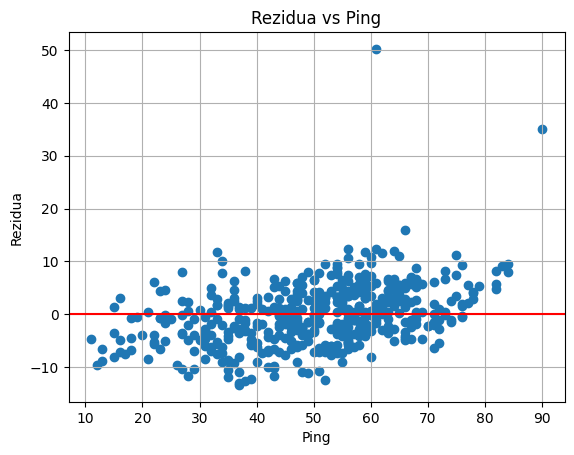

In [30]:
# graf rezidui
# res vs ping
plt.scatter(dfSt['ping'], resModel.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.title("Rezidua vs Ping")
plt.xlabel("Ping")
plt.ylabel("Rezidua")

plt.show()

In [28]:
influence = resModel.get_influence()
# Leverage
leverage = influence.hat_matrix_diag
# Cookovy D hodnoty (a p-hodnoty) jako n-tice polí [n x 2]
cooks_d = influence.cooks_distance
# Standardizovaná rezidua
standardized_residuals = influence.resid_studentized_internal
# Studentizovaná rezidua
studentized_residuals = influence.resid_studentized_external

#tabulka dohromady dořešit změny počtu řádků
outl_stats_df = pd.DataFrame({
    'Leverage': leverage,
    'Standardized Residuals': standardized_residuals,
    'Studentized Residuals': studentized_residuals,
    'Cook\'s Distance': cooks_d[0],
    'Cook\'s Distance_p-value': cooks_d[1]
}, index=dfSt.index)
#vyber jen "zajímavý" hodnoty
outl_stats_df = outl_stats_df[(outl_stats_df['Leverage'] > 3*len(resModel.params)/dfSt.shape[0]) | (np.abs(outl_stats_df['Standardized Residuals']) > 2) | (outl_stats_df['Cook\'s Distance_p-value'] < 0.05)]


print(outl_stats_df)

     Leverage  Standardized Residuals  Studentized Residuals  Cook's Distance  \
62   0.012590               -2.036977              -2.043554         0.004810   
82   0.010646                2.699228               2.716710         0.007127   
114  0.012955                2.111260               2.118748         0.005318   
129  0.014222               -2.141213              -2.149089         0.006013   
145  0.023780               -2.292470              -2.302490         0.011638   
178  0.047086                2.054883               2.061673         0.018968   
254  0.011482                2.011917               2.018204         0.004274   
255  0.009986                5.945469               6.165493         0.032412   
310  0.016649               -2.111115              -2.118601         0.006860   
332  0.030075                2.124928               2.132592         0.012728   
428  0.028086                2.048785               2.055502         0.011027   
430  0.017414               

Podľa grafu reziduí je vidieť, že sa dve hodnoty veľmi líšia od ostatných - sú to hľadané outliery. Podľa výpočtu štandardizovaných a študentizovaných reziduí sú najviac líšiace sa merania s indexmi 255 a 476. Preto ich v ďalšom kroku odstránim a znovu vizualizujem graf reziduí.

In [39]:
# vymazanie outlierov
outlierIndxs = [255,476]
print(f"Drop: {outlierIndxs}")
dfStNoOut = dfSt.drop(index=outlierIndxs)

Drop: [255, 476]


In [43]:
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android'
finalModel = buildModelSummary(formula, dfStNoOut)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.28e-215
Time:                        12:22:34   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

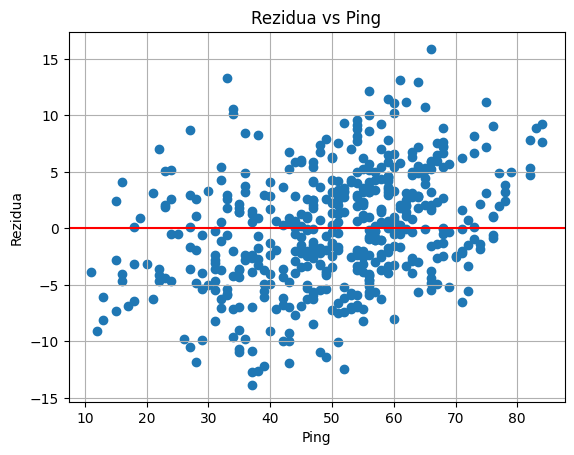

In [44]:
# graf rezidui
# res vs ping
plt.scatter(dfStNoOut['ping'], finalModel.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.title("Rezidua vs Ping")
plt.xlabel("Ping")
plt.ylabel("Rezidua")

plt.show()

Odstránil som správne dve hodnoty a model sa podľa koeficientu determinácie zlepšil z 0.843 na 0.877. Odstránené hodnoty mohli byť valídne avšak bolo by potreba viac dát s podobnými hodnotami aby som ich mohol použiť.

Teraz je model hotový.